In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import numpy as np
from pandas import Series
import seaborn as sns
from matplotlib.pyplot import figure
import cmocean.cm as cmo
import seaborn as sns

from pylab import rcParams
from numpy import diff
from scipy import interpolate
import scipy.stats as stats

from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

import matplotlib.gridspec as gridspec

import cmocean
import cmocean.cm as cmo
import seaborn as sns


import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

## import data

In [2]:
df_o2 = pd.read_csv('../Dissertation_projects/Data/CTD/O2_Summary_Stats.csv', sep=',', index_col=0)

In [3]:
df_iron = pd.read_csv('../Dissertation_projects/Data/IRON/Iron.csv', sep=',', index_col=0)

#make all the spots labeled NA a nan value
df_iron = df_iron.replace('NA', np.nan)
df_iron = df_iron.replace('NA ', np.nan)

#make all BDL a 0 
df_iron.loc[df_iron['FeT_uM'] == 'BLD', 'FeT_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] == 'BLD', 'Fe2_uM'] = 0

# convert columns to numeric data type
df_iron['FeT_uM'] = pd.to_numeric(df_iron['FeT_uM'], errors='coerce')
df_iron['Fe2_uM'] = pd.to_numeric(df_iron['Fe2_uM'], errors='coerce')

df_iron['FeT_uM'] = df_iron['FeT_uM'].where(pd.notna(df_iron['FeT_uM']), other=np.nan)
df_iron['Fe2_uM'] = df_iron['Fe2_uM'].where(pd.notna(df_iron['Fe2_uM']), other=np.nan)

#make all negative a 0 
df_iron.loc[df_iron['FeT_uM'] < 0, 'FeT_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] < 0, 'Fe2_uM'] = 0

#calculate Fe +3 
df_iron['Fe3_uM'] = df_iron['FeT_uM'] - df_iron['Fe2_uM']
df_iron.loc[df_iron['Fe3_uM'] < 0, 'Fe3_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] > df_iron['FeT_uM'], 'Fe3_uM'] = 0
df_iron['Fe3_uM'] = pd.to_numeric(df_iron['Fe3_uM'], errors='coerce')
df_iron['Fe3_uM'] = df_iron['Fe3_uM'].where(pd.notna(df_iron['Fe3_uM']), other=np.nan)

#time feild 
df_iron['Fe2_Time'] = pd.to_numeric(df_iron['Fe2_Time'], errors='coerce')
df_iron['Fe2_Time'] = df_iron['Fe2_Time'].where(pd.notna(df_iron['Fe2_Time']), other=np.nan)

#time feild 
df_iron['FeT_Time'] = pd.to_numeric(df_iron['FeT_Time'], errors='coerce')
df_iron['FeT_Time'] = df_iron['FeT_Time'].where(pd.notna(df_iron['FeT_Time']), other=np.nan)

# convert columns to numeric data type
df_iron['FeT_Depth'] = pd.to_numeric(df_iron['Fe2_Depth'], errors='coerce')
df_iron['Fe2_Depth'] = pd.to_numeric(df_iron['Fe2_Depth'], errors='coerce')

df_iron['code'] = df_iron['Location'] + '_' + df_iron['Campaign']

In [4]:
df_meta = pd.read_csv('../Dissertation_projects/Data/meta_data.csv', sep=',', index_col=0)

#fix date time 
df_meta['date_time'] = pd.to_datetime(df_meta['Date'])
df_meta['Date'] = df_meta['date_time'].dt.date

df_meta['code'] = df_meta['Station'] + '_' + df_meta['Trip']

In [5]:
df_por = pd.read_csv('../Dissertation_projects/Data/Porosity/Porosity.csv', sep=',', index_col = 0)
df_por['code'] = df_por['Stn'] + '_' + df_por['camp']

In [6]:
df_hights = pd.read_csv('../Dissertation_projects/Data/Hights.csv', sep=',')

df_hights['code'] = df_hights['Stn'] + '_' + df_hights['Camp']
#df_hights.drop("Stn", axis=1, inplace=True)
#df_hights.drop("Camp", axis=1, inplace=True)
df_hights.index = df_hights['code']
df_hights.drop("code", axis=1, inplace=True)

In [7]:
#get BC data sets 
df_iron_bc = df_iron[df_iron['Type'] == 'BC']

#get PW data sets 
df_iron_pw = df_iron[df_iron['Type'] == 'PW']

#get WC data sets 
df_iron_wc = df_iron[df_iron['Type'] == 'WC']

#get RHZ data 
df_iron_rz = df_iron[df_iron['Type'].isin(['RZ', 'GBRZ'])]

## Data for flux calculations 

In [8]:
#hights data
df_hights = pd.read_csv('../Dissertation_projects/Data/Hights.csv', sep=',')

df_hights['code'] = df_hights['Stn'] + '_' + df_hights['Camp']
#df_hights.drop("Stn", axis=1, inplace=True)
#df_hights.drop("Camp", axis=1, inplace=True)
df_hights.index = df_hights['code']
df_hights.drop("code", axis=1, inplace=True)

In [9]:
#porosity data 
df_por = pd.read_csv('../Dissertation_projects/Data/Porosity/Porosity.csv', sep=',', index_col = 0)
df_por['code'] = df_por['Stn'] + '_' + df_por['camp']

In [10]:
#location data 
df_lat_lon = df_meta.groupby('code').agg({'Lat': 'mean', 'Lon': 'mean'}).reset_index().set_index('code')

## slope calculations

In [11]:
#figure calculate pore water 
#get PW data sets 
df_iron_pw = df_iron[df_iron['Type'] == 'PW']
#Fe2 and Fe3 slopes
#df_iron_pw = df_iron_pw[(df_iron_pw['Fe2_uM'] != 0)]
#df_iron_pw = df_iron_pw[(df_iron_pw['Fe2_Depth'] > 0)]
df_iron_pw = df_iron_pw.dropna(subset=["Fe2_uM"])
df_iron_pw = df_iron_pw.sort_values(by='code')
codes = df_iron_pw['code'].unique()

print(codes)
len(codes)

['St.11_GOM2021' 'St.11_GOM21FA' 'St.11_GOM22SU' 'St.12_GOM21FA'
 'St.12_GOM22SU' 'St.13_GOM21FA' 'St.13_GOM22SP' 'St.13_GOM22SU'
 'St.14_GOM2021' 'St.14_GOM21FA' 'St.14_GOM22SP' 'St.14_GOM22SU'
 'St.15_GOM2021' 'St.15_GOM21FA' 'St.15_GOM22SP' 'St.15_GOM22SU'
 'St.16_GOM2021' 'St.16_GOM21FA' 'St.16_GOM22SP' 'St.16_GOM22SU'
 'St.2_GOM2021' 'St.2_GOM21FA' 'St.2_GOM22SP' 'St.2_GOM22SU'
 'St.4_GOM2021' 'St.4_GOM21FA' 'St.4_GOM22SP' 'St.4_GOM22SU'
 'St.5B_GOM2021' 'St.5B_GOM21FA' 'St.5B_GOM22SP' 'St.5B_GOM22SU'
 'St.7_GOM2021' 'St.7_GOM21FA' 'St.7_GOM22SP' 'St.7_GOM22SU'
 'St.9_GOM2021' 'St.9_GOM21FA' 'St.9_GOM22SP' 'St.9_GOM22SU'
 'St.MK_GOM2021' 'St.MK_GOM21FA' 'St.MK_GOM22SP' 'St.MK_GOM22SU']


44

In [12]:
#df_concatenated = pd.concat([df_iron_pw, df_iron_wc_plot], ignore_index=True)
#df_iron_pw = df_iron_wc_plot.sort_values(by='code')
df_iron_pw['code'].unique()

array(['St.11_GOM2021', 'St.11_GOM21FA', 'St.11_GOM22SU', 'St.12_GOM21FA',
       'St.12_GOM22SU', 'St.13_GOM21FA', 'St.13_GOM22SP', 'St.13_GOM22SU',
       'St.14_GOM2021', 'St.14_GOM21FA', 'St.14_GOM22SP', 'St.14_GOM22SU',
       'St.15_GOM2021', 'St.15_GOM21FA', 'St.15_GOM22SP', 'St.15_GOM22SU',
       'St.16_GOM2021', 'St.16_GOM21FA', 'St.16_GOM22SP', 'St.16_GOM22SU',
       'St.2_GOM2021', 'St.2_GOM21FA', 'St.2_GOM22SP', 'St.2_GOM22SU',
       'St.4_GOM2021', 'St.4_GOM21FA', 'St.4_GOM22SP', 'St.4_GOM22SU',
       'St.5B_GOM2021', 'St.5B_GOM21FA', 'St.5B_GOM22SP', 'St.5B_GOM22SU',
       'St.7_GOM2021', 'St.7_GOM21FA', 'St.7_GOM22SP', 'St.7_GOM22SU',
       'St.9_GOM2021', 'St.9_GOM21FA', 'St.9_GOM22SP', 'St.9_GOM22SU',
       'St.MK_GOM2021', 'St.MK_GOM21FA', 'St.MK_GOM22SP', 'St.MK_GOM22SU'],
      dtype=object)

In [13]:
df_o2

,camp,station,date,Max_pressure,Pressure_dbar_surface,O2_mgL_surface,latitude_surface,longitude_surface,Pressure_dbar_bottom,O2_mgL_bottom,...,temp_surface,temp_bottom,sal_surface,sal_bottom,O2_uM_surface,O2_uM_bottom,code.1,Slope,Slope_pressure,Slope_pressure_percent
code,,,,,,,,,,,,,,,,,,,,,
St.11_GOM2021,GOM2021,St.11,2021-07-25,946.986,2.076,7.3366,28.21678,-89.54664,946.986,7.8471,...,29.9854,5.1025,36.1896,34.9346,229.275915,245.229538,St.11_GOM2021,0.163220,568.175,40.001753
St.13_GOM2021,GOM2021,St.13,2021-07-21,321.519,2.283,6.2980,28.53696,-89.49614,321.519,5.5889,...,29.8063,11.2036,35.0741,35.3737,196.818651,174.658583,St.13_GOM2021,-0.054545,303.323,5.659386
St.14_GOM2021,GOM2021,St.14,2021-07-19,91.278,1.829,6.3473,28.72514,-89.60390,91.278,4.9078,...,30.2016,19.1043,31.1088,36.4047,198.359324,153.373543,St.14_GOM2021,-3.150723,65.016,28.771445
St.15_GOM2021,GOM2021,St.15,2021-07-23,287.295,2.191,9.0433,28.94254,-88.83508,287.295,5.4067,...,29.4733,11.3417,29.3293,35.3946,282.611957,168.964655,St.15_GOM2021,-0.113588,239.206,16.738544
St.16_GOM2021,GOM2021,St.16,2021-07-24,61.804,1.277,7.4623,28.88042,-89.54684,61.804,5.2200,...,29.8499,20.7100,20.4683,36.3277,233.204163,163.130098,St.16_GOM2021,-7.128514,49.449,19.990615
St.2_GOM2021,GOM2021,St.2,2021-07-22,63.413,2.074,6.8821,28.89964,-89.59322,63.413,4.7733,...,28.9431,20.7587,27.5856,36.3022,215.072346,149.170287,St.2_GOM2021,-6.845005,56.271,11.262675
St.4_GOM2021,GOM2021,St.4,2021-07-17,17.437,1.145,8.2318,28.79886,-90.71040,17.437,2.9017,...,30.3120,27.7279,24.8396,35.3894,257.251789,90.680959,St.4_GOM2021,-26.043628,11.138,36.124333
St.5B_GOM2021,GOM2021,St.5B,2021-07-16,12.856,1.505,7.6929,28.81030,-91.34152,12.856,7.1658,...,29.8254,28.7477,29.1495,33.7462,240.410638,223.938248,St.5B_GOM2021,2.028044,10.106,21.390790
St.7_GOM2021,GOM2021,St.7,2021-07-26,39.529,1.736,9.3420,28.91830,-89.87558,39.529,3.9643,...,30.1656,24.3561,25.4665,36.0396,291.946623,123.888247,St.7_GOM2021,-5.125902,31.053,21.442485


C:\Users\hmlbr\AppData\Local\Temp\ipykernel_29508\789254689.py:11: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  yy = sub.loc[(sub['Fe2_Depth'] < depth1) & (sub['Fe2_Depth'] > depth2), 'Fe2_Depth'].ravel()
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_29508\789254689.py:12: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  xx = sub.loc[(sub['Fe2_Depth'] < depth1) & (sub['Fe2_Depth'] > depth2), 'Fe2_uM'].ravel()
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_29508\789254689.py:27: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  xx2 = sub.loc[(sub['Fe2_Depth'] < depth1) & (sub['Fe2_Depth'] > depth2), 'Fe2_Depth'].ravel() / 100
C:\Users\hmlbr\

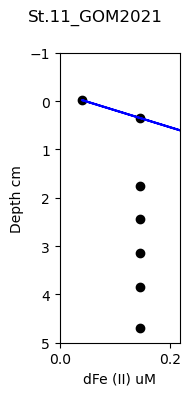

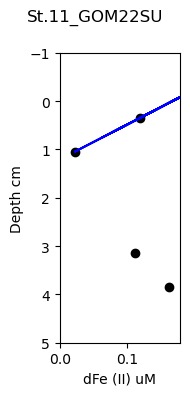

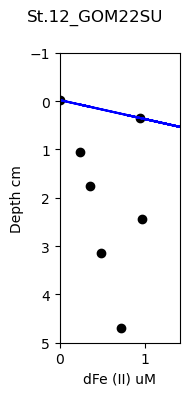

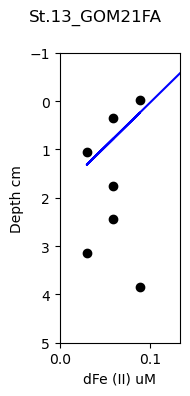

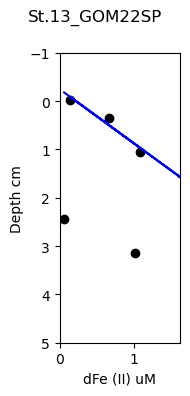

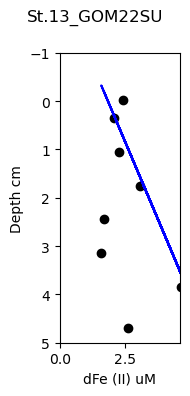

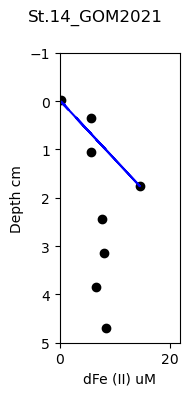

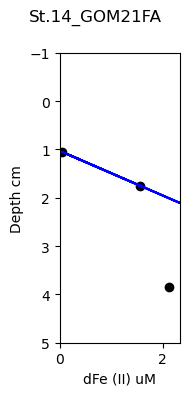

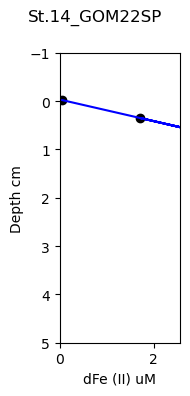

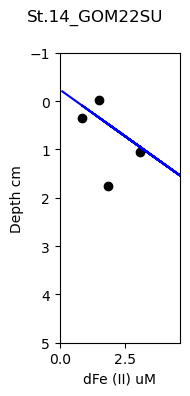

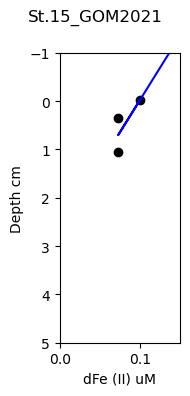

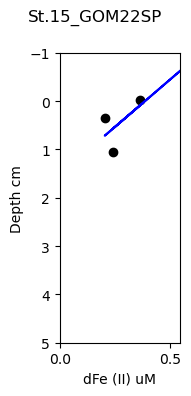

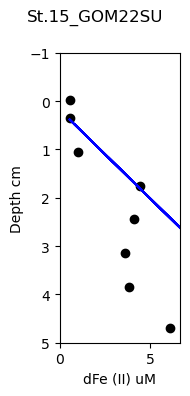

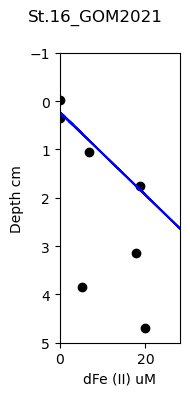

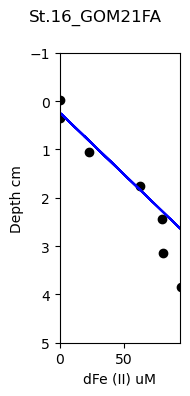

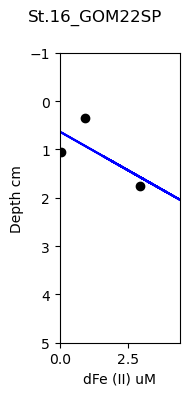

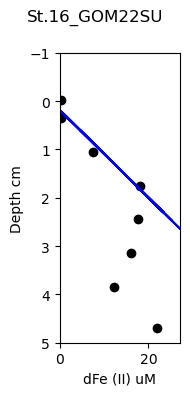

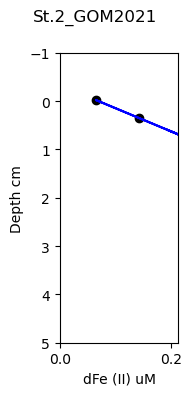

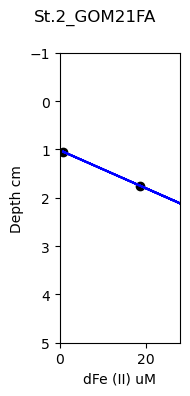

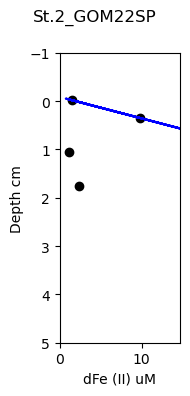

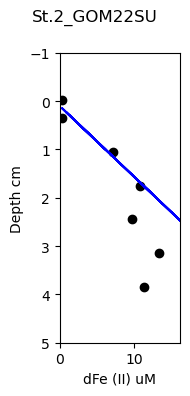

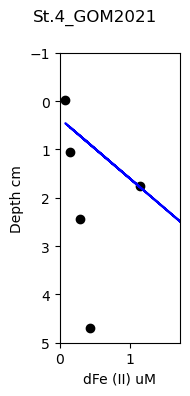

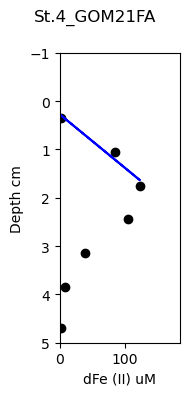

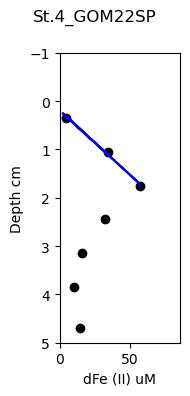

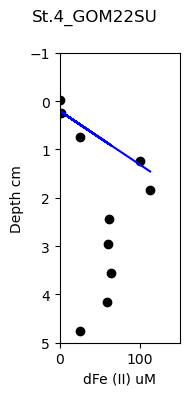

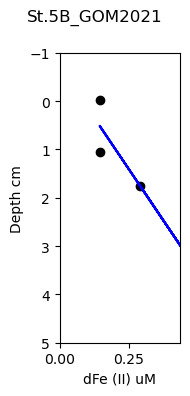

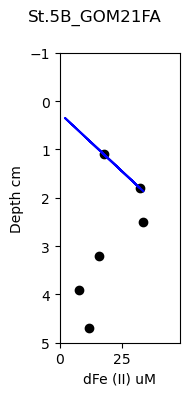

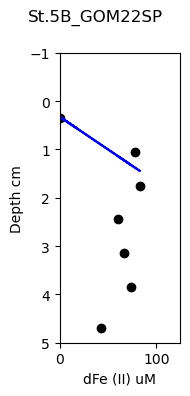

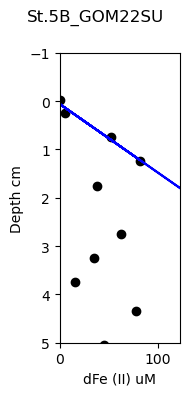

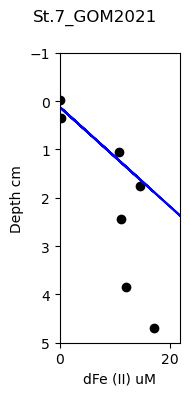

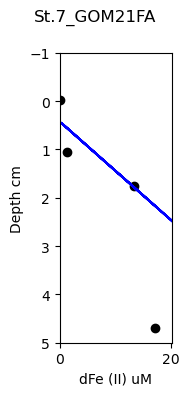

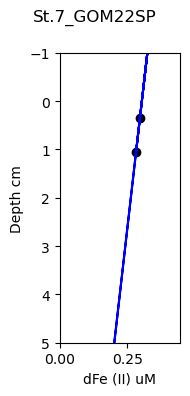

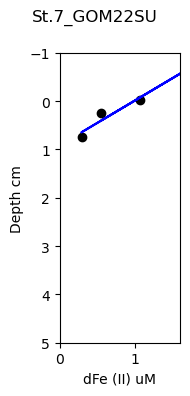

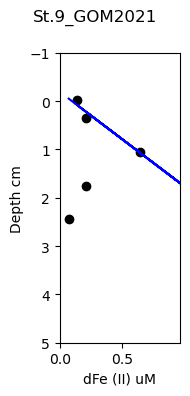

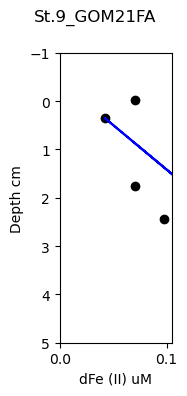

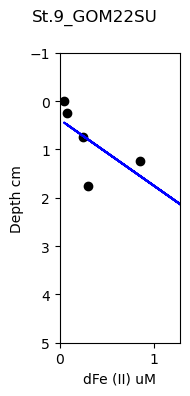

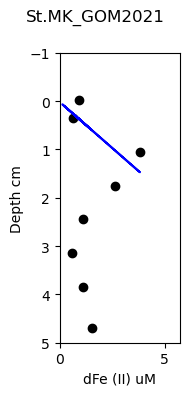

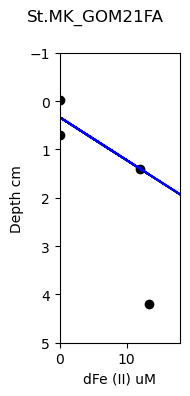

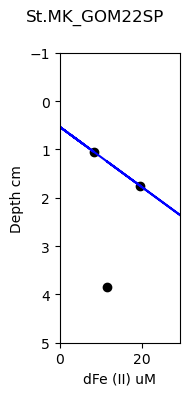

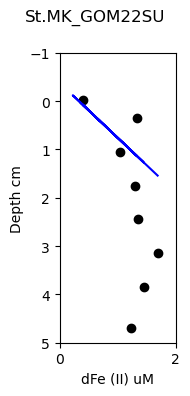

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_29508\789254689.py:119: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  slopes_fe2_pw['por_mean'].fillna(0.85, inplace=True)
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_29508\789254689.py:120: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

,slope_fe2_pw,rsquared_fe2_pw,std_err_fe2_pw_slope,flux_fe2_depth_pw,por_mean,por_sd,std_err_por,por_count,Temp,D_fe2,por_SE,pw_flux_fe2,pw_flux_fe2_error,Lat,Lon,Stn,Camp
code,,,,,,,,,,,,,,,,,
St.11_GOM2021,28.378378,1.000000,0.000000,0.35,0.894263,0.004941,0.002853,3.0,5.1025,0.000004,0.002853,0.000896,0.000000e+00,28.225724,-89.540904,St.11,GOM2021
St.11_GOM22SU,-13.857143,1.000000,0.000000,1.05,0.911245,0.004821,0.002783,3.0,5.3683,0.000004,0.002783,-0.000450,-0.000000e+00,28.202880,-89.581503,St.11,GOM22SU
St.12_GOM22SU,254.054054,1.000000,0.000000,0.35,0.860954,0.013093,0.009258,2.0,5.1780,0.000004,0.009258,0.007742,0.000000e+00,28.593063,-88.878258,St.12,GOM22SU
St.13_GOM21FA,-1.731274,0.316592,1.798625,1.75,0.908008,0.004741,0.002371,4.0,9.7036,0.000005,0.002371,-0.000065,-1.119144e-07,28.524193,-89.610854,St.13,GOM21FA
St.13_GOM22SP,84.147804,0.942302,20.822316,1.05,0.881930,0.009893,0.004946,4.0,8.6982,0.000005,0.004946,0.002965,5.545618e-08,28.507026,-89.622720,St.13,GOM22SP
St.13_GOM22SU,39.760969,0.503892,27.897266,1.75,0.879924,0.020249,0.014318,2.0,8.7615,0.000005,0.014318,0.001401,4.571294e-07,28.524547,-89.597871,St.13,GOM22SU
St.14_GOM2021,703.447455,0.858969,201.551028,1.75,0.849480,0.020559,0.010279,4.0,19.1043,0.000006,0.010279,0.031936,1.852948e-07,28.726863,-89.601437,St.14,GOM2021
St.14_GOM21FA,216.857143,1.000000,0.000000,1.75,0.841244,0.027246,0.013623,4.0,17.8378,0.000006,0.013623,0.009450,0.000000e+00,28.727625,-89.620568,St.14,GOM21FA
St.14_GOM22SP,447.250953,1.000000,0.000000,0.35,0.869609,0.023847,0.011923,4.0,20.2709,0.000006,0.011923,0.021374,0.000000e+00,28.726195,-89.613151,St.14,GOM22SP


In [14]:
Frames = []

def fe2_flux_cal(code, depth1, depth2): 
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(2, 4))
    sub = df_iron_pw[df_iron_pw['code'] == code]
    y = sub['Fe2_Depth']
    x = sub['Fe2_uM']
    #er = sub['NPOC_uM_std']
    axs.scatter(x, y, c="black")
    #axs.errorbar(x, y, xerr=er, fmt='none', ecolor='black', capsize=5)
    yy = sub.loc[(sub['Fe2_Depth'] < depth1) & (sub['Fe2_Depth'] > depth2), 'Fe2_Depth'].ravel() 
    xx = sub.loc[(sub['Fe2_Depth'] < depth1) & (sub['Fe2_Depth'] > depth2), 'Fe2_uM'].ravel()

    max_depth = max(yy)
    
    # Add subplot labels
    axs.set_xlabel('dFe (II) uM')
    axs.set_ylabel('Depth cm')
    axs.set_ylim(5,-1)
    axs.set_xlim(0,max(xx)*1.5)
    
    if len(xx) > 1:
        # Add the slope value to the plot
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)
        axs.plot(x, intercept + slope * x, c='blue')
        
        xx2 = sub.loc[(sub['Fe2_Depth'] < depth1) & (sub['Fe2_Depth'] > depth2), 'Fe2_Depth'].ravel() / 100 
        yy2 = sub.loc[(sub['Fe2_Depth'] < depth1) & (sub['Fe2_Depth'] > depth2), 'Fe2_uM'].ravel() 
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx2, yy2)
        
        slope = slope
        rsquared = r_value**2
        std_err = std_err 
        
    df_p = df_por.loc[df_por['code'] == code]
    df_por_data = df_p.loc[(df_p['depth'] < depth1) & (df_p['depth'] > 0), 'porosity'].ravel() 
    por_mean = df_por_data.mean()
    por_std = df_por_data.std()
    std_err_por = por_std / np.sqrt(len(df_por_data)) 
    por_count = len(df_por_data)

    # Infinite-dilution diffusion coefficients of the main ions in seawater (dependent of temperature only) - [cm^2 s^-1]
    # Temperature in oC
    temp = df_o2[df_o2['code.1'] == code]
    T =  temp['temp_bottom']
    D_Fe = (3.32 + 0.15 * T) * 1e-6  # Fe2+
    #D_fe = 7.07e-06 / 10000 * (86400)
    
    dic = {'code':[code],
           'slope_fe2_pw':[slope],
           'rsquared_fe2_pw':[rsquared], 
           'std_err_fe2_pw_slope':[std_err], 
           'flux_fe2_depth_pw': [max_depth], 
           'por_mean':por_mean,
           'por_sd': por_std,
           'std_err_por': std_err_por,
           'por_count':por_count, 
           'Temp':T,
           'D_fe2':D_Fe}
        
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    Frames.append(slopes)
        
    # Add subplot labels
    fig.suptitle(code)
    plt.tight_layout()
    fig.set_facecolor('w')
    #plt.savefig(f'../Dissertation_projects/Figures/Pore_water_profiles/flux_profiles/doc_{code}.png')
    plt.show()

fe2_flux_cal('St.11_GOM2021', 1.5, -1)
#fe2_flux_cal('St.11_GOM21FA', 2.5, -1)
fe2_flux_cal('St.11_GOM22SU', 1.5, -1)
#fe2_flux_cal('St.12_GOM21FA', 2, -1)
fe2_flux_cal('St.12_GOM22SU', 1, -1)
fe2_flux_cal('St.13_GOM21FA', 2, -1)
fe2_flux_cal('St.13_GOM22SP', 2, -1)
fe2_flux_cal('St.13_GOM22SU', 2, -1)
fe2_flux_cal('St.14_GOM2021', 2, -1)
fe2_flux_cal('St.14_GOM21FA', 2, -1)
fe2_flux_cal('St.14_GOM22SP', 2, -1)
fe2_flux_cal('St.14_GOM22SU', 1.5, -1)
fe2_flux_cal('St.15_GOM2021', 1.5, -1)
#fe2_flux_cal('St.15_GOM21FA', 2, -1)
fe2_flux_cal('St.15_GOM22SP', 1.5, -1)
fe2_flux_cal('St.15_GOM22SU', 2, -1)
fe2_flux_cal('St.16_GOM2021', 2, -1)
fe2_flux_cal('St.16_GOM21FA', 2, -1)
fe2_flux_cal('St.16_GOM22SP', 2, -1)
fe2_flux_cal('St.16_GOM22SU', 2, -1)
fe2_flux_cal('St.2_GOM2021', 1, -1)
fe2_flux_cal('St.2_GOM21FA', 2, -1)
fe2_flux_cal('St.2_GOM22SP', 1, -1)
fe2_flux_cal('St.2_GOM22SU', 2, -1)
fe2_flux_cal('St.4_GOM2021', 2, -1)
fe2_flux_cal('St.4_GOM21FA', 2, -1)
fe2_flux_cal('St.4_GOM22SP', 2, -1)
fe2_flux_cal('St.4_GOM22SU', 1.5, -1)
fe2_flux_cal('St.5B_GOM2021', 2, -1)
fe2_flux_cal('St.5B_GOM21FA', 2, -1)
fe2_flux_cal('St.5B_GOM22SP', 2, -1)
fe2_flux_cal('St.5B_GOM22SU', 1.5, -1)
fe2_flux_cal('St.7_GOM2021', 2, -1)
fe2_flux_cal('St.7_GOM21FA', 2, -1)
fe2_flux_cal('St.7_GOM22SP', 2, -1)
fe2_flux_cal('St.7_GOM22SU', 1, -1)
fe2_flux_cal('St.9_GOM2021', 1.5, -1)
fe2_flux_cal('St.9_GOM21FA', 2, -1)
#fe2_flux_cal('St.9_GOM22SP', 2, -1)
fe2_flux_cal('St.9_GOM22SU', 2, -1)
fe2_flux_cal('St.MK_GOM2021', 2, -1)
fe2_flux_cal('St.MK_GOM21FA', 2, -1)
fe2_flux_cal('St.MK_GOM22SP', 2, -1)
fe2_flux_cal('St.MK_GOM22SU', 2, -1)

slopes_fe2_pw = pd.concat(Frames, axis=0, ignore_index=False)

slopes_fe2_pw['por_mean'].fillna(0.85, inplace=True)
slopes_fe2_pw['por_sd'].fillna(0, inplace=True)
slopes_fe2_pw['por_SE'] = slopes_fe2_pw['por_sd'] / (np.sqrt(slopes_fe2_pw['por_count']))
slopes_fe2_pw['por_SE'].fillna(0, inplace=True)


slopes_fe2_pw["pw_flux_fe2"] = slopes_fe2_pw["slope_fe2_pw"] * (slopes_fe2_pw["por_mean"] ) * (slopes_fe2_pw["D_fe2"] / 10000 * (86400) )
slopes_fe2_pw["pw_flux_fe2_error"] = (slopes_fe2_pw["std_err_fe2_pw_slope"] / slopes_fe2_pw["slope_fe2_pw"]) * (slopes_fe2_pw["por_SE"] / slopes_fe2_pw["por_mean"]) * (slopes_fe2_pw["D_fe2"] / 10000 * (86400) ) 

slopes_fe2_pw = pd.concat([slopes_fe2_pw, df_lat_lon], axis=1, join='outer')
slopes_fe2_pw['Stn'] = slopes_fe2_pw.index.str.split('_').str[0]
slopes_fe2_pw['Camp'] = slopes_fe2_pw.index.str.split('_').str[1]
slopes_fe2_pw = slopes_fe2_pw.dropna(subset=['pw_flux_fe2'])

slopes_fe2_pw

In [15]:
#figure calculate pore water 
df_iron_pw = df_iron[df_iron['Type'] == 'PW']

#Fe2 and Fe3 slopes
#df_iron_pw = df_iron_pw[(df_iron_pw['Fe3_uM'] != 0)]
#df_iron_pw = df_iron_pw[(df_iron_pw['FeT_Depth'] > 0)]
df_iron_pw = df_iron_pw.dropna(subset=["Fe3_uM"])
df_iron_pw = df_iron_pw.sort_values(by='code')
codes = df_iron_pw['code'].unique()

print(codes)
len(codes)

['St.11_GOM2021' 'St.11_GOM21FA' 'St.11_GOM22SU' 'St.12_GOM21FA'
 'St.12_GOM22SU' 'St.13_GOM21FA' 'St.13_GOM22SP' 'St.13_GOM22SU'
 'St.14_GOM2021' 'St.14_GOM21FA' 'St.14_GOM22SP' 'St.14_GOM22SU'
 'St.15_GOM2021' 'St.15_GOM21FA' 'St.15_GOM22SP' 'St.15_GOM22SU'
 'St.16_GOM2021' 'St.16_GOM21FA' 'St.16_GOM22SP' 'St.16_GOM22SU'
 'St.2_GOM2021' 'St.2_GOM21FA' 'St.2_GOM22SP' 'St.2_GOM22SU'
 'St.4_GOM2021' 'St.4_GOM21FA' 'St.4_GOM22SP' 'St.4_GOM22SU'
 'St.5B_GOM2021' 'St.5B_GOM21FA' 'St.5B_GOM22SP' 'St.5B_GOM22SU'
 'St.7_GOM2021' 'St.7_GOM21FA' 'St.7_GOM22SP' 'St.7_GOM22SU'
 'St.9_GOM2021' 'St.9_GOM21FA' 'St.9_GOM22SP' 'St.9_GOM22SU'
 'St.MK_GOM2021' 'St.MK_GOM21FA' 'St.MK_GOM22SP' 'St.MK_GOM22SU']


44

In [16]:
#df_iron_wc_plot = df_iron_wc[df_iron_wc['code'].isin(codes)]

#max_depth_per_code = df_iron_wc_plot.groupby('code')['FeT_Depth'].max().reset_index()
#df_iron_wc_plot = pd.merge(df_iron_wc_plot, max_depth_per_code, on='code', suffixes=('', '_max'))
#df_iron_wc_plot = df_iron_wc_plot[df_iron_wc_plot['FeT_Depth'] == df_iron_wc_plot['FeT_Depth_max']]
#df_iron_wc_plot.drop(columns=['FeT_Depth_max'], inplace=True)

#df_iron_wc_plot['Depth_sample'] = df_iron_wc_plot['FeT_Depth']
#df_iron_wc_plot['FeT_Depth'] = -0.5
#df_iron_wc_plot

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_29508\430848286.py:11: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  yy = sub.loc[(sub['FeT_Depth'] < depth1) & (sub['FeT_Depth'] > depth2), 'FeT_Depth'].ravel()
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_29508\430848286.py:12: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  xx = sub.loc[(sub['FeT_Depth'] < depth1) & (sub['FeT_Depth'] > depth2), 'Fe3_uM'].ravel()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 

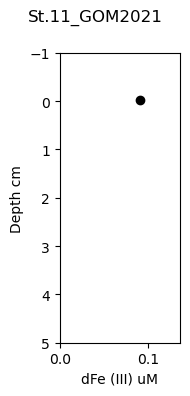

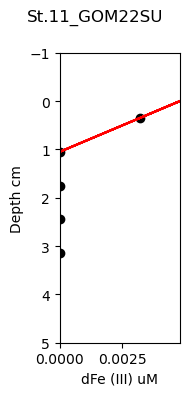

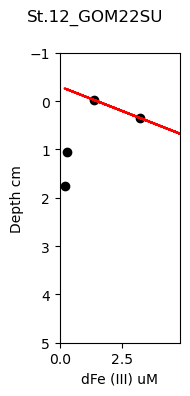

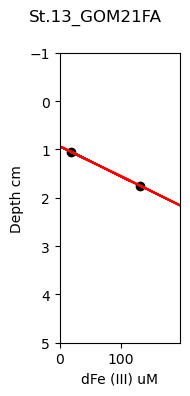

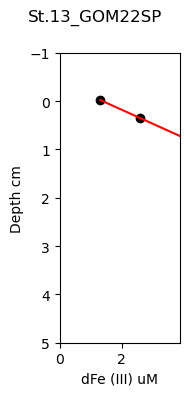

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_29508\430848286.py:28: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  xx2 = sub.loc[(sub['FeT_Depth'] < depth1) & (sub['FeT_Depth'] > depth2), 'FeT_Depth'].ravel() / 100
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_29508\430848286.py:29: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  yy2 = sub.loc[(sub['FeT_Depth'] < depth1) & (sub['FeT_Depth'] > depth2), 'Fe3_uM'].ravel()
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_29508\430848286.py:37: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  df_por_data = df_p.loc[(df_p['depth'] < depth1) & (df_p['depth'] > 0), 'porosity'].ravel()


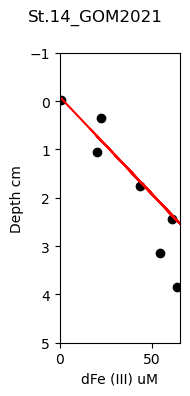

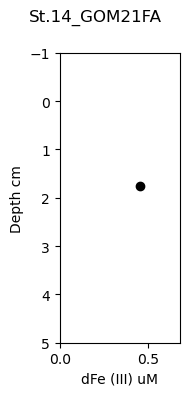

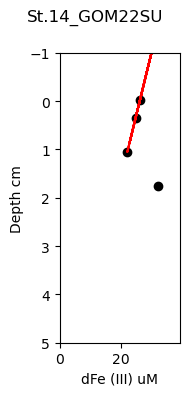

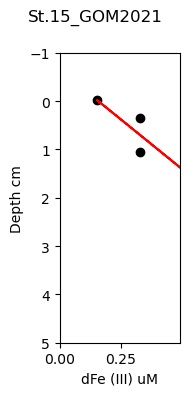

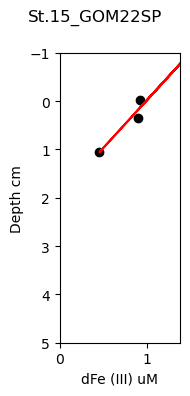

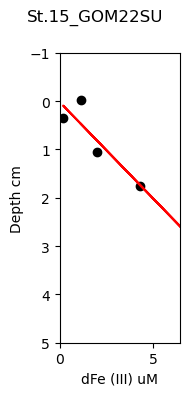

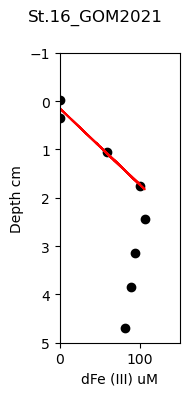

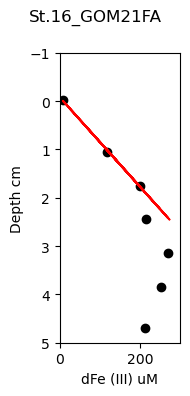

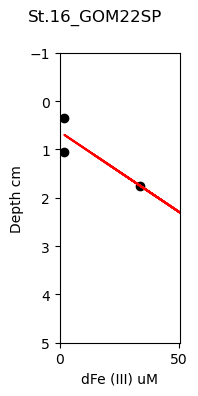

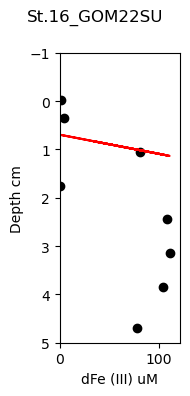

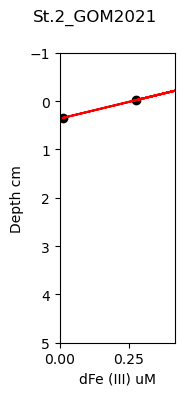

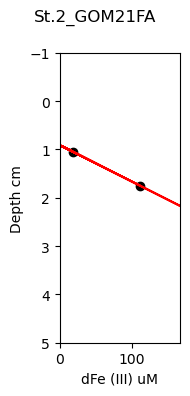

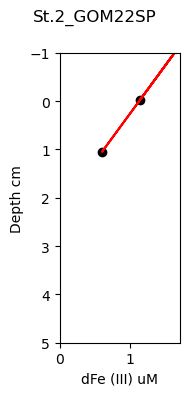

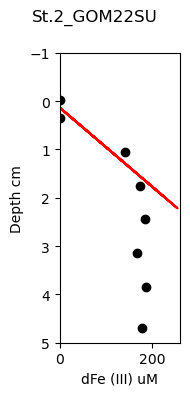

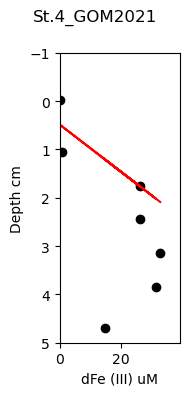

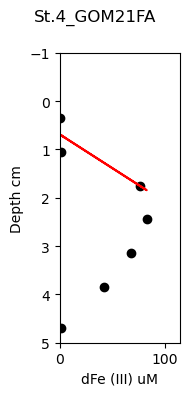

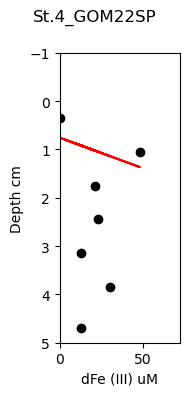

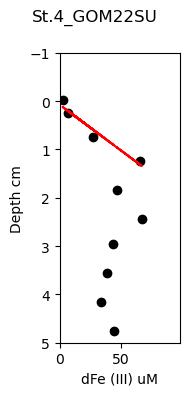

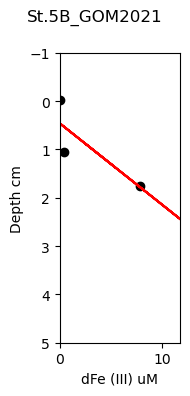

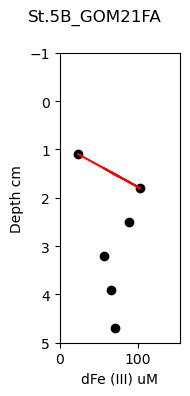

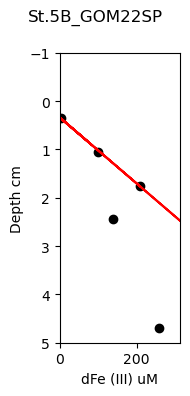

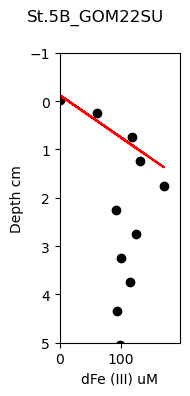

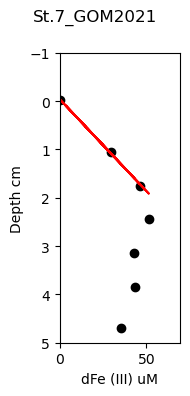

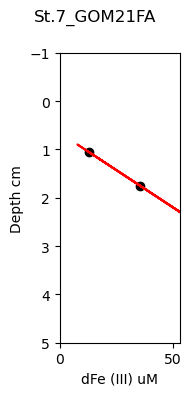

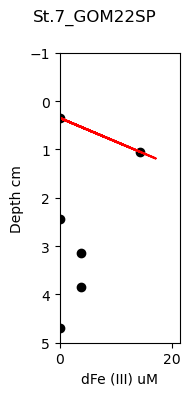

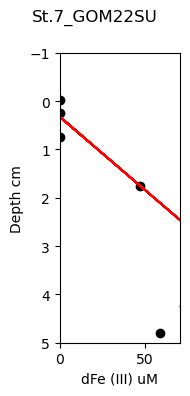

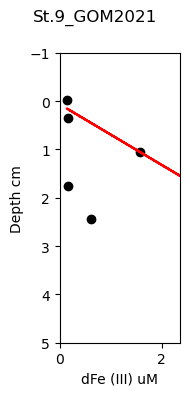

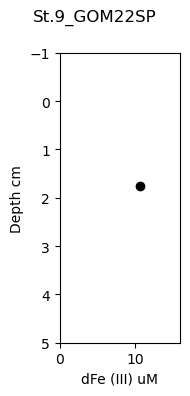

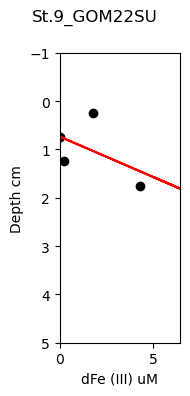

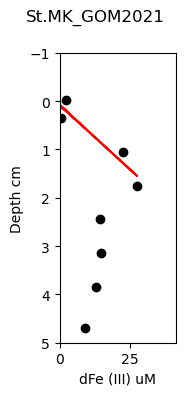

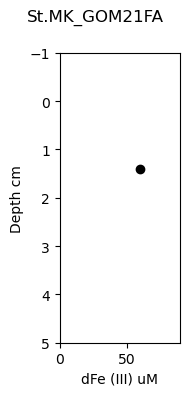

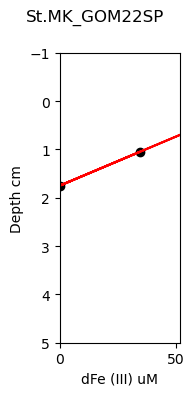

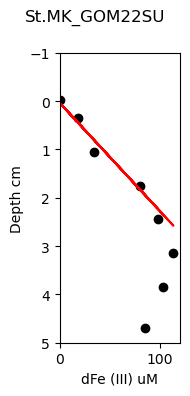

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_29508\430848286.py:120: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  slopes_fe3_pw['por_mean'].fillna(0.85, inplace=True)
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_29508\430848286.py:121: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

,slope_fe3_pw,rsquared_fe3_pw,std_err_fe3_pw_slope,flux_fe3_depth_pw,por_mean,por_sd,std_err_por,por_count,Temp,D_fe3,por_SE,pw_flux_fe3,pw_flux_fe3_error,Lat,Lon,Stn,Camp
code,,,,,,,,,,,,,,,,,
St.14_GOM2021,2028.951691,0.816237,680.734681,1.75,0.849480,0.020559,0.010279,4.0,19.1043,0.000006,0.010279,0.092114,2.169782e-07,28.726863,-89.601437,St.14,GOM2021
St.14_GOM22SU,-384.533017,0.999970,2.101180,1.05,0.880874,0.016127,0.009311,3.0,18.8476,0.000006,0.009311,-0.017990,-3.067494e-09,28.728776,-89.620647,St.14,GOM22SU
St.15_GOM2021,14.222824,0.585168,11.975179,1.05,0.922137,0.021725,0.012543,3.0,11.3417,0.000005,0.012543,0.000569,4.968447e-07,28.942528,-88.835023,St.15,GOM2021
St.15_GOM22SP,-46.123008,0.908570,14.631256,1.05,0.913622,0.010354,0.005978,3.0,12.4002,0.000005,0.005978,-0.001886,-9.289498e-08,28.944296,-88.860281,St.15,GOM22SP
St.15_GOM22SU,201.160075,0.801490,70.789425,1.75,0.918533,0.012584,0.006292,4.0,12.7663,0.000005,0.006292,0.008357,1.090335e-07,28.950645,-88.842176,St.15,GOM22SU
St.16_GOM2021,6079.464696,0.963455,837.242489,1.75,0.884978,0.004250,0.002125,4.0,20.7100,0.000006,0.002125,0.298735,1.836163e-08,28.876302,-89.547035,St.16,GOM2021
St.16_GOM21FA,10811.254667,0.998711,388.443945,1.75,0.851314,0.023436,0.011718,4.0,22.3907,0.000007,0.011718,0.531087,2.853805e-08,28.885048,-89.542132,St.16,GOM21FA
St.16_GOM22SP,2260.382895,0.750115,1304.630961,1.75,0.856684,0.017920,0.008960,4.0,21.4083,0.000007,0.008960,0.109273,3.406529e-07,28.914785,-89.545059,St.16,GOM22SP
St.16_GOM22SU,1010.012509,0.039818,3507.098277,1.75,0.863702,0.015762,0.007881,4.0,22.9855,0.000007,0.007881,0.051010,1.852709e-06,28.891260,-89.536424,St.16,GOM22SU


In [17]:
Frames = []

def fe2_flux_cal(code, depth1, depth2): 
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(2, 4))
    sub = df_iron_pw[df_iron_pw['code'] == code]
    y = sub['FeT_Depth']
    x = sub['Fe3_uM']
    #er = sub['NPOC_uM_std']
    axs.scatter(x, y, c="black")
    #axs.errorbar(x, y, xerr=er, fmt='none', ecolor='black', capsize=5)
    yy = sub.loc[(sub['FeT_Depth'] < depth1) & (sub['FeT_Depth'] > depth2), 'FeT_Depth'].ravel() 
    xx = sub.loc[(sub['FeT_Depth'] < depth1) & (sub['FeT_Depth'] > depth2), 'Fe3_uM'].ravel()

    max_depth = max(yy)
    
    # Add subplot labels
    axs.set_xlabel('dFe (III) uM')
    axs.set_ylabel('Depth cm')
    axs.set_ylim(5,-1)
    axs.set_xlim(0,max(xx)*1.5)

    # Add the slope value to the plot
    slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)
    axs.plot(x, intercept + slope * x, c='red')
    
    if len(xx) > 2:
        
        xx2 = sub.loc[(sub['FeT_Depth'] < depth1) & (sub['FeT_Depth'] > depth2), 'FeT_Depth'].ravel() / 100 
        yy2 = sub.loc[(sub['FeT_Depth'] < depth1) & (sub['FeT_Depth'] > depth2), 'Fe3_uM'].ravel() 
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx2, yy2)
        
        slope = slope
        rsquared = r_value**2
        std_err = std_err 

        df_p = df_por.loc[df_por['code'] == code]
        df_por_data = df_p.loc[(df_p['depth'] < depth1) & (df_p['depth'] > 0), 'porosity'].ravel() 
        por_mean = df_por_data.mean()
        por_std = df_por_data.std()
        std_err_por = por_std / np.sqrt(len(df_por_data)) 
        por_count = len(df_por_data)

        # Infinite-dilution diffusion coefficients of the main ions in seawater (dependent of temperature only) - [cm^2 s^-1]
        # Temperature in oC
        temp = df_o2[df_o2['code.1'] == code]
        T =  temp['temp_bottom']
        D_Fe = (3.32 + 0.15 * T) * 1e-6  # Fe2+
        #D_fe = 7.07e-06 / 10000 * (86400)
    
        dic = {'code':[code],
               'slope_fe3_pw':[slope],
               'rsquared_fe3_pw':[rsquared], 
               'std_err_fe3_pw_slope':[std_err], 
               'flux_fe3_depth_pw': [max_depth], 
               'por_mean':por_mean,
               'por_sd': por_std,
               'std_err_por': std_err_por,
               'por_count':por_count, 
               'Temp':T,
               'D_fe3':D_Fe}
        
        slopes = pd.DataFrame(dic)
        slopes = slopes.set_index('code', drop=True)
        Frames.append(slopes)
        
        # Add subplot labels
    fig.suptitle(code)
    plt.tight_layout()
    fig.set_facecolor('w')
    #plt.savefig(f'../Dissertation_projects/Figures/Pore_water_profiles/flux_profiles/doc_{code}.png')
    plt.show()

fe2_flux_cal('St.11_GOM2021', 1.5, -1)
#fe2_flux_cal('St.11_GOM21FA', 1, -1)
fe2_flux_cal('St.11_GOM22SU', 1.5, -1)
#fe2_flux_cal('St.12_GOM21FA', 2, -1)
fe2_flux_cal('St.12_GOM22SU', 1, -1)
fe2_flux_cal('St.13_GOM21FA', 2, -1)
fe2_flux_cal('St.13_GOM22SP', 2, -1)
#fe2_flux_cal('St.13_GOM22SU', 2, -1)
fe2_flux_cal('St.14_GOM2021', 2, -1)
fe2_flux_cal('St.14_GOM21FA', 2, -1)
#fe2_flux_cal('St.14_GOM22SP', 2, -1)
fe2_flux_cal('St.14_GOM22SU', 1.5, -1)
fe2_flux_cal('St.15_GOM2021', 1.5, -1)
#fe2_flux_cal('St.15_GOM21FA', 2, -1)
fe2_flux_cal('St.15_GOM22SP', 1.5, -1)
fe2_flux_cal('St.15_GOM22SU', 2, -1)
fe2_flux_cal('St.16_GOM2021', 2, -1)
fe2_flux_cal('St.16_GOM21FA', 2, -1)
fe2_flux_cal('St.16_GOM22SP', 2, -1)
fe2_flux_cal('St.16_GOM22SU', 2, -1)
fe2_flux_cal('St.2_GOM2021', 1, -1)
fe2_flux_cal('St.2_GOM21FA', 2, -1)
fe2_flux_cal('St.2_GOM22SP', 1.5, -1)
fe2_flux_cal('St.2_GOM22SU', 2, -1)
fe2_flux_cal('St.4_GOM2021', 2, -1)
fe2_flux_cal('St.4_GOM21FA', 2, -1)
fe2_flux_cal('St.4_GOM22SP', 2, -1)
fe2_flux_cal('St.4_GOM22SU', 1.5, -1)
fe2_flux_cal('St.5B_GOM2021', 2, -1)
fe2_flux_cal('St.5B_GOM21FA', 2, -1)
fe2_flux_cal('St.5B_GOM22SP', 2, -1)
fe2_flux_cal('St.5B_GOM22SU', 1.5, -1)
fe2_flux_cal('St.7_GOM2021', 2, -1)
fe2_flux_cal('St.7_GOM21FA', 2, -1)
fe2_flux_cal('St.7_GOM22SP', 2, -1)
fe2_flux_cal('St.7_GOM22SU', 2, -1)
fe2_flux_cal('St.9_GOM2021', 1.5, -1)
#fe2_flux_cal('St.9_GOM21FA', 2, -1)
fe2_flux_cal('St.9_GOM22SP', 2, -1)
fe2_flux_cal('St.9_GOM22SU', 2, -1)
fe2_flux_cal('St.MK_GOM2021', 2, -1)
fe2_flux_cal('St.MK_GOM21FA', 2, -1)
fe2_flux_cal('St.MK_GOM22SP', 2, -1)
fe2_flux_cal('St.MK_GOM22SU', 2, -1)

slopes_fe3_pw = pd.concat(Frames, axis=0, ignore_index=False)

slopes_fe3_pw['por_mean'].fillna(0.85, inplace=True)
slopes_fe3_pw['por_sd'].fillna(0, inplace=True)
slopes_fe3_pw['por_SE'] = slopes_fe3_pw['por_sd'] / (np.sqrt(slopes_fe3_pw['por_count']))
slopes_fe3_pw['por_SE'].fillna(0, inplace=True)

slopes_fe3_pw["pw_flux_fe3"] = slopes_fe3_pw["slope_fe3_pw"] * (slopes_fe3_pw["por_mean"]) * (slopes_fe3_pw["D_fe3"] / 10000 * (86400))
slopes_fe3_pw["pw_flux_fe3_error"] = (slopes_fe3_pw["std_err_fe3_pw_slope"] / slopes_fe3_pw["slope_fe3_pw"]) * (slopes_fe3_pw["por_SE"] / slopes_fe3_pw["por_mean"]) * (slopes_fe3_pw["D_fe3"] / 10000 * (86400))

slopes_fe3_pw = pd.concat([slopes_fe3_pw, df_lat_lon], axis=1, join='outer')
slopes_fe3_pw['Stn'] = slopes_fe3_pw.index.str.split('_').str[0]
slopes_fe3_pw['Camp'] = slopes_fe3_pw.index.str.split('_').str[1]
slopes_fe3_pw = slopes_fe3_pw.dropna(subset=['pw_flux_fe3'])

slopes_fe3_pw

In [18]:
slopes_fe2_pw.to_csv('../Dissertation_projects/Data/Stats_data_sets/Flux_fe2_pw.csv')
slopes_fe2_pw

,slope_fe2_pw,rsquared_fe2_pw,std_err_fe2_pw_slope,flux_fe2_depth_pw,por_mean,por_sd,std_err_por,por_count,Temp,D_fe2,por_SE,pw_flux_fe2,pw_flux_fe2_error,Lat,Lon,Stn,Camp
code,,,,,,,,,,,,,,,,,
St.11_GOM2021,28.378378,1.000000,0.000000,0.35,0.894263,0.004941,0.002853,3.0,5.1025,0.000004,0.002853,0.000896,0.000000e+00,28.225724,-89.540904,St.11,GOM2021
St.11_GOM22SU,-13.857143,1.000000,0.000000,1.05,0.911245,0.004821,0.002783,3.0,5.3683,0.000004,0.002783,-0.000450,-0.000000e+00,28.202880,-89.581503,St.11,GOM22SU
St.12_GOM22SU,254.054054,1.000000,0.000000,0.35,0.860954,0.013093,0.009258,2.0,5.1780,0.000004,0.009258,0.007742,0.000000e+00,28.593063,-88.878258,St.12,GOM22SU
St.13_GOM21FA,-1.731274,0.316592,1.798625,1.75,0.908008,0.004741,0.002371,4.0,9.7036,0.000005,0.002371,-0.000065,-1.119144e-07,28.524193,-89.610854,St.13,GOM21FA
St.13_GOM22SP,84.147804,0.942302,20.822316,1.05,0.881930,0.009893,0.004946,4.0,8.6982,0.000005,0.004946,0.002965,5.545618e-08,28.507026,-89.622720,St.13,GOM22SP
St.13_GOM22SU,39.760969,0.503892,27.897266,1.75,0.879924,0.020249,0.014318,2.0,8.7615,0.000005,0.014318,0.001401,4.571294e-07,28.524547,-89.597871,St.13,GOM22SU
St.14_GOM2021,703.447455,0.858969,201.551028,1.75,0.849480,0.020559,0.010279,4.0,19.1043,0.000006,0.010279,0.031936,1.852948e-07,28.726863,-89.601437,St.14,GOM2021
St.14_GOM21FA,216.857143,1.000000,0.000000,1.75,0.841244,0.027246,0.013623,4.0,17.8378,0.000006,0.013623,0.009450,0.000000e+00,28.727625,-89.620568,St.14,GOM21FA
St.14_GOM22SP,447.250953,1.000000,0.000000,0.35,0.869609,0.023847,0.011923,4.0,20.2709,0.000006,0.011923,0.021374,0.000000e+00,28.726195,-89.613151,St.14,GOM22SP


In [19]:
slopes_fe3_pw.to_csv('../Dissertation_projects/Data/Stats_data_sets/Flux_fe3_pw.csv')
slopes_fe3_pw

,slope_fe3_pw,rsquared_fe3_pw,std_err_fe3_pw_slope,flux_fe3_depth_pw,por_mean,por_sd,std_err_por,por_count,Temp,D_fe3,por_SE,pw_flux_fe3,pw_flux_fe3_error,Lat,Lon,Stn,Camp
code,,,,,,,,,,,,,,,,,
St.14_GOM2021,2028.951691,0.816237,680.734681,1.75,0.849480,0.020559,0.010279,4.0,19.1043,0.000006,0.010279,0.092114,2.169782e-07,28.726863,-89.601437,St.14,GOM2021
St.14_GOM22SU,-384.533017,0.999970,2.101180,1.05,0.880874,0.016127,0.009311,3.0,18.8476,0.000006,0.009311,-0.017990,-3.067494e-09,28.728776,-89.620647,St.14,GOM22SU
St.15_GOM2021,14.222824,0.585168,11.975179,1.05,0.922137,0.021725,0.012543,3.0,11.3417,0.000005,0.012543,0.000569,4.968447e-07,28.942528,-88.835023,St.15,GOM2021
St.15_GOM22SP,-46.123008,0.908570,14.631256,1.05,0.913622,0.010354,0.005978,3.0,12.4002,0.000005,0.005978,-0.001886,-9.289498e-08,28.944296,-88.860281,St.15,GOM22SP
St.15_GOM22SU,201.160075,0.801490,70.789425,1.75,0.918533,0.012584,0.006292,4.0,12.7663,0.000005,0.006292,0.008357,1.090335e-07,28.950645,-88.842176,St.15,GOM22SU
St.16_GOM2021,6079.464696,0.963455,837.242489,1.75,0.884978,0.004250,0.002125,4.0,20.7100,0.000006,0.002125,0.298735,1.836163e-08,28.876302,-89.547035,St.16,GOM2021
St.16_GOM21FA,10811.254667,0.998711,388.443945,1.75,0.851314,0.023436,0.011718,4.0,22.3907,0.000007,0.011718,0.531087,2.853805e-08,28.885048,-89.542132,St.16,GOM21FA
St.16_GOM22SP,2260.382895,0.750115,1304.630961,1.75,0.856684,0.017920,0.008960,4.0,21.4083,0.000007,0.008960,0.109273,3.406529e-07,28.914785,-89.545059,St.16,GOM22SP
St.16_GOM22SU,1010.012509,0.039818,3507.098277,1.75,0.863702,0.015762,0.007881,4.0,22.9855,0.000007,0.007881,0.051010,1.852709e-06,28.891260,-89.536424,St.16,GOM22SU


## Benthic Chamber

#figure calculate Benthic chamber 

#Fe2 slops
#df_iron_bc_fe2_cl = df_iron_bc.drop(df_iron_bc[(df_iron_bc['Fe2_uM'] == 0) | (df_iron_bc['Fe2_uM'].isna())].index)
df_iron_bc_fe2_cl = df_iron_bc.drop(df_iron_bc[(df_iron_bc['Fe2_uM'] == np.nan) | (df_iron_bc['Fe2_uM'].isna())].index)
codes = df_iron_bc_fe2_cl['code'].unique()

print(codes)
len(codes)

Frames = []

def fe2_flux_cal(code, time1, time2): 
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 3)) 
    sub = df_iron_bc_fe2_cl.loc[df_iron_bc_fe2_cl['code'] == codes[code]]
    x = sub['Fe2_Time']
    y = sub['Fe2_uM']
    axs.scatter(x, y, c="black")
    xx = sub.loc[(sub['Fe2_Time'] < time1) & (sub['Fe2_Time'] > time2), 'Fe2_Time'].ravel()
    yy = sub.loc[(sub['Fe2_Time'] < time1) & (sub['Fe2_Time'] > time2), 'Fe2_uM'].ravel()
    if len(x) > 1:
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)
        axs.plot(x, intercept + slope * x, c='b')
        # Add the slope value to the plot
        slope = slope
        rsquared = r_value**2
        std_err = std_err
        
        dic = {'code':[codes[code]],
               'slope_fe2_bc':[slope],
               'rsquared_fe2_bc':[rsquared], 
               'std_err_fe2_bc':[std_err], 
               'flux_time_fe2_bc': [time1]}
        
        slopes = pd.DataFrame(dic)
        slopes = slopes.set_index('code', drop=True)
        Frames.append(slopes)
        
    # Add subplot labels
    axs.set_xlabel('Time in Hours')
    axs.set_ylabel('Fe2 uM')
    axs.set_xlim(0,df_iron_bc_fe2_cl['Fe2_Time'].max())
    #axs.set_ylim(df_iron_bc_fe2_cl['Fe2_uM'].min(),df_iron_bc_fe2_cl['Fe2_uM'].max())
    axs.set_ylim(0,.2)
    fig.suptitle(codes[code])
    plt.tight_layout()
    fig.set_facecolor('w')
    plt.show()
    
fe2_flux_cal(0, 6, .5)
fe2_flux_cal(1, 12, 0)
fe2_flux_cal(2, 5, 0)
#fe2_flux_cal(3, 2, 0)
fe2_flux_cal(4, 6, 1)
fe2_flux_cal(5, 7, 1)
fe2_flux_cal(6, 12, 0)
fe2_flux_cal(7, 10, 0)
fe2_flux_cal(8, 12, 0)
fe2_flux_cal(9, 12, 0)
fe2_flux_cal(10, 12, 0)
fe2_flux_cal(11, 12, 0)
fe2_flux_cal(12, 12, 0)
fe2_flux_cal(13, 10, 0)
fe2_flux_cal(14, 10, 0)
fe2_flux_cal(15, 12, 0)
fe2_flux_cal(18, 12, 0)
fe2_flux_cal(19, 8, 0)
fe2_flux_cal(20, 8, 0)
fe2_flux_cal(21, 3, 0)
fe2_flux_cal(22, 8, 0)
fe2_flux_cal(23, 8, 0)
fe2_flux_cal(24, 8, 0)
fe2_flux_cal(25, 11, 0)
fe2_flux_cal(26, 12, 0)
fe2_flux_cal(27, 8, 0)
fe2_flux_cal(28, 12, 0)
fe2_flux_cal(29, 5, 0.5)
fe2_flux_cal(30, 3, 0)
fe2_flux_cal(31, 3, 0)
fe2_flux_cal(32, 8, 0)
fe2_flux_cal(33, 10, 0)
fe2_flux_cal(34, 8, 0)
fe2_flux_cal(35, 10, 0)
fe2_flux_cal(36, 6, 0)
fe2_flux_cal(37, 8, 1)

slopes_fe2_bc = pd.concat(Frames, axis=0, ignore_index=False)

slopes_fe2_bc = pd.concat([slopes_fe2_bc, df_hights, df_lat_lon], axis=1, join='outer')
slopes_fe2_bc = slopes_fe2_bc.dropna(subset=['slope_fe2_bc'])

slopes_fe2_bc["bc_flux_fe2"] = slopes_fe2_bc["slope_fe2_bc"] * slopes_fe2_bc["Hight_m"] * 24 
slopes_fe2_bc["bc_flux_fe2_error"] = slopes_fe2_bc["std_err_fe2_bc"] * slopes_fe2_bc["Hight_m"] * 24 

slopes_fe2_bc  

#figure calculate Benthic chamber 

#Fe3 slops
#df_iron_bc_fe3_cl = df_iron_bc.drop(df_iron_bc[(df_iron_bc['Fe3_uM'] == 0) | (df_iron_bc['Fe3_uM'].isna())].index)
df_iron_bc_fe3_cl = df_iron_bc.drop(df_iron_bc[(df_iron_bc['Fe3_uM'] == np.nan) | (df_iron_bc['Fe3_uM'].isna())].index)
codes = df_iron_bc_fe3_cl['code'].unique()

print(codes)
len(codes)

Frames = []

def fe3_flux_cal(code, time1, time2): 
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 3)) 
    sub = df_iron_bc_fe3_cl.loc[df_iron_bc_fe2_cl['code'] == codes[code]]
    x = sub['FeT_Time']
    y = sub['Fe3_uM']
    axs.scatter(x, y, c="black")
    xx = sub.loc[(sub['FeT_Time'] < time1) & (sub['FeT_Time'] > time2), 'FeT_Time'].ravel()
    yy = sub.loc[(sub['FeT_Time'] < time1) & (sub['FeT_Time'] > time2), 'Fe3_uM'].ravel()
    if len(x) > 1:
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)
        axs.plot(x, intercept + slope * x, c='r')
        # Add the slope value to the plot
        slope = slope
        rsquared = r_value**2
        std_err = std_err
        
        dic = {'code':[codes[code]],
               'slope_fe3_bc':[slope],
               'rsquared_fe3_bc':[rsquared], 
               'std_err_fe3_bc':[std_err], 
               'flux_time_fe3_bc': [time1]}
        
        slopes = pd.DataFrame(dic)
        slopes = slopes.set_index('code', drop=True)
        Frames.append(slopes)
        
    # Add subplot labels
    axs.set_xlabel('Time in Hours')
    axs.set_ylabel('Fe3 uM')
    axs.set_xlim(0,df_iron_bc_fe3_cl['FeT_Time'].max())
    #axs.set_ylim(df_iron_bc_fe3_cl['Fe3_uM'].min(),df_iron_bc_fe3_cl['Fe3_uM'].max())
    fig.suptitle(codes[code])
    plt.tight_layout()
    fig.set_facecolor('w')
    plt.show()
    
fe3_flux_cal(0, 10, 0)
fe3_flux_cal(1, 2, 0)
fe3_flux_cal(2, 12, 0)
fe3_flux_cal(4, 10, 0)
fe3_flux_cal(5, 15, 1)
fe3_flux_cal(6, 6, 0)
fe3_flux_cal(7, 3, 0)
fe3_flux_cal(8, 6, 1)
fe3_flux_cal(9, 6, 0)
fe3_flux_cal(10, 6, 0)
fe3_flux_cal(11, 20, 0)
fe3_flux_cal(12, 15, 0)
fe3_flux_cal(13, 14, 0)
fe3_flux_cal(14, 9, 0)
fe3_flux_cal(15, 8, 0)
fe3_flux_cal(17, 11, 0)
fe3_flux_cal(18, 5, 0)
fe3_flux_cal(19, 8, 0)
fe3_flux_cal(20, 10, 0)
fe3_flux_cal(21, 10, 0)
fe3_flux_cal(22, 16, 0)
fe3_flux_cal(23, 5, 0)
fe3_flux_cal(24, 5, 0)
fe3_flux_cal(25, 12, 0)
fe3_flux_cal(26, 7, 0)
fe3_flux_cal(27, 13, 0)
fe3_flux_cal(28, 5, 0)

slopes_fe3_bc = pd.concat(Frames, axis=0, ignore_index=False)

slopes_fe3_bc = pd.concat([slopes_fe3_bc, df_hights, df_lat_lon], axis=1, join='outer')
slopes_fe3_bc = slopes_fe3_bc.dropna(subset=['slope_fe3_bc'])

slopes_fe3_bc["bc_flux_fe3"] = slopes_fe3_bc["slope_fe3_bc"] * slopes_fe3_bc["Hight_m"]* 24 
slopes_fe3_bc["bc_flux_fe3_error"] = slopes_fe3_bc["std_err_fe3_bc"] * slopes_fe3_bc["Hight_m"]* 24 

slopes_fe3_bc 

slopes_fe3_bc.to_csv('../Dissertation_projects/Data/Stats_data_sets/Flux_fe3_bc.csv')
slopes_fe3_bc

slopes_fe2_bc.to_csv('../Dissertation_projects/Data/Stats_data_sets/Flux_fe2_bc.csv')
slopes_fe2_bc